## Import necessary libraries

In [62]:
# Clear memory
%reset -f

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [125]:
# System imports
import sys
import importlib
from pathlib import Path
import pandas as pd

# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Project setup
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Project modules
MODULES = [
    'iowa_dream.utils',
    'iowa_dream.data', 
    'iowa_dream.feature_engineering',
    'iowa_dream.feature_engineering.lot_frontage_imputer',
    'iowa_dream.evaluation',
    'iowa_dream.evaluation.metrics_plot',
    'iowa_dream.models.optuna_objective',
    'iowa_dream.models.custom_obj_lgbm'
]

# Reload modules
for module in MODULES:
    if module in sys.modules:
        importlib.reload(sys.modules[module])
    else:
        __import__(module)

# Project imports
from iowa_dream.data.importer import load_config
from iowa_dream.utils.sample_split import create_sample_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from lightgbm import LGBMRegressor
from glum import GeneralizedLinearRegressor, GeneralizedLinearRegressorCV
from iowa_dream.feature_engineering.lot_frontage_imputer import LotFrontageGroupMedianImputer
from iowa_dream.feature_engineering.add_drop_features import Add_Drop_Attributes
from iowa_dream.feature_engineering.categotical_transformer import OrdinalMerger, NominalGrouper
from iowa_dream.feature_engineering.numerical_transformer import WinsorizedRobustScaler
from iowa_dream.evaluation.metrics_plot import reevaluate_models, analyze_glm_coefficients, plot_learning_curve
from iowa_dream.models.optuna_objective import optuna_objective
from iowa_dream.models.custom_obj_lgbm import custom_regression_loss
import dalex as dx
from sklearn.model_selection import GridSearchCV

import optuna

## Import data and config

In [93]:
# Example usage
data_file = project_root / load_config()['kaggle']['cleaned_path'] / 'cleaned_AmesHousing.parquet'
df = pd.read_parquet(data_file)

In [94]:
# Get data dictionary from config
config = load_config()
cleaned_data_dict = config['cleaned_data_dict']

# Extract feature groups
ordinal_features = cleaned_data_dict['ordinal']['columns']
nominal_features = cleaned_data_dict['nominal']['columns'] 
discrete_features = cleaned_data_dict['discrete']['columns']
continuous_features = cleaned_data_dict['continuous']['columns']
numeric_features = continuous_features + discrete_features
proximity_data = {
    neighborhood: group['category'] 
    for group in config['university_proximity']
    for neighborhood in group['neighborhoods']
}
glm_data_dict = config['glm_data_dict']
glm_ordinal_features = glm_data_dict['categorical']['ordinal']['columns']
glm_nominal_features = glm_data_dict['categorical']['nominal']['columns']
glm_numerical_features = glm_data_dict['numerical']['columns']

## Split data

In [95]:
df = create_sample_split(df, 'pid')
train_df = df[df['sample'] == 'train']
test_df = df[df['sample'] == 'test']
y = df['saleprice']

# Separate features (X) and target (y)
X_train = train_df.drop(['saleprice', 'sample', 'pid'], axis=1)
y_train = train_df['saleprice']
X_test = test_df.drop(['saleprice', 'sample', 'pid'], axis=1)
y_test = test_df['saleprice']

# 0. Baseline median predictor

In [70]:
# Create and fit a baseline model that predicts the mean
baseline_mean = DummyRegressor(strategy='mean')
baseline_mean.fit(X_train, y_train)

# Evaluate the baseline model
reevaluate_models([baseline_mean], X_train, y_train, model_names=['Mean Predictor'])


,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Mean Predictor,79450.24,43.83%,38.00%,46270.42,0.00,0.00,6312340835.56


#1. Baseline GLM

In [71]:
baseline_preprocessor = ColumnTransformer(
    transformers=[
        (
            "group_impute",
            LotFrontageGroupMedianImputer(
                group_cols=['neighborhood', 'lot_config'],
                target_col='lot_frontage'
            ),
            ['neighborhood', 'lot_config', 'lot_frontage'],
        ),
        ("cat", OneHotEncoder(sparse_output=False, drop="first", handle_unknown='ignore'), nominal_features),
    ]
)
baseline_preprocessor.set_output(transform="pandas")
baseline_GLM_model_pipeline = Pipeline(
    [
        ("preprocess", baseline_preprocessor),
        (
            "estimate",
            GeneralizedLinearRegressor(
                family='gamma', l1_ratio=1, fit_intercept=True
            ),
        ),
    ]
)
baseline_GLM_model_pipeline.fit(X_train, y_train)
reevaluate_models([baseline_GLM_model_pipeline], X_train, y_train)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,39739.53,21.92%,16.47%,19772.31,0.75,-109.70,1579229847.53


This is already quite good :), indicating that our model is capturing quite well the pattern in the data. 

# 2. GLM with combined (added features) and processed data

In [72]:
# Preprocessing pipeline for numerical features

numerical_pipeline = Pipeline(steps=[
    ('winsorized_scaler', WinsorizedRobustScaler(range_min=10, range_max=99))
])

# Preprocessing pipeline for ordinal features
ordinal_pipeline = Pipeline(steps=[
    ('ordinal_merger', OrdinalMerger(min_obs=10))
])

# Preprocessing pipeline for nominal features
nominal_pipeline = Pipeline(steps=[
    ('nominal_grouper', NominalGrouper(min_obs=10)),
    ('onehot', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
])

# Combine preprocessing pipelines
glm_preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, glm_numerical_features),
    ('ord', ordinal_pipeline, glm_ordinal_features),
    ('nom', nominal_pipeline, glm_nominal_features)
])

# Full pipeline
glm_1_pipeline = Pipeline(steps=[
    ('imputer', LotFrontageGroupMedianImputer(group_cols=['neighborhood', 'lot_config'], target_col='lot_frontage')),
    ('feature_add_drop', Add_Drop_Attributes(proximity_data=proximity_data)),
    ('preprocessor', glm_preprocessor),
    ('glm', GeneralizedLinearRegressor(family='gamma', link='log', l1_ratio=1, fit_intercept=True))  # GeneralizedLinearRegressor equivalent for gamma family
])

glm_1_pipeline

Pipeline(steps=[('imputer',
                 LotFrontageGroupMedianImputer(group_cols=['neighborhood',
                                                           'lot_config'],
                                               target_col='lot_frontage')),
                ('feature_add_drop',
                 Add_Drop_Attributes(proximity_data={'Blmngtn': 3, 'Blueste': 1,
                                                     'BrDale': 2, 'BrkSide': 4,
                                                     'ClearCr': 3, 'CollgCr': 4,
                                                     'Crawfor': 4, 'Edwards': 3,
                                                     'Gilbert': 1, 'Greens': 1,
                                                     'GrnHill': 1, 'IDOTRR': 4,
                                                     'Landmrk': 4, 'MeadowV': 3,
                                                     'Mi...
                                                   'university_proximity_category',
                                                   'has_2nd_floor',
                                                   'has_wood_deck']),
                                                 ('nom',
                                                  Pipeline(steps=[('nominal_grouper',
                                                                   NominalGrouper()),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['exterior_1st', 'foundation',
                                                   'mas_vnr_type',
                                                   'season_indicator',
                                                   'lot_config'])])),
                ('glm',
                 GeneralizedLinearRegressor(family='gamma', l1_ratio=1,
                                            link='log'))])

In [73]:
# Fit and evaluate
glm_1_pipeline.fit(X_train, y_train)
reevaluate_models([baseline_GLM_model_pipeline, glm_1_pipeline], X_train, y_train)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,39739.53,21.92%,16.47%,19772.31,0.75,-109.70,1579229847.53
Model 2,21330.47,11.77%,9.21%,10413.38,0.93,80.56,454988873.78


In [128]:
reevaluate_models([baseline_GLM_model_pipeline,  glm_1_pipeline], X_test, y_test)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,44376.30,25.23%,16.92%,18936.76,0.64,-4433.45,1969256183.04
Model 2,22821.78,12.98%,9.37%,10450.47,0.90,307.96,520833670.82


In [139]:
# Define interaction terms
interaction_features = [
    ('age', 'exter_qu'),
    ('gr_liv_area', 'overall_score'),
    ('gr_liv_area', 'neighborhood_score'), 
    ('gr_liv_area', 'age'),
]

# Preprocessing pipeline for interaction terms
interaction_pipeline = Pipeline(steps=[
    ('interaction', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('winsorized_scaler', WinsorizedRobustScaler(range_min=10, range_max=99))  # Use WinsorizedRobustScaler to standardize
])

# Combine preprocessing pipelines
glm_with_interaction_preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, glm_numerical_features),
    ('ord', ordinal_pipeline, glm_ordinal_features),
    ('nom', nominal_pipeline, glm_nominal_features),
    ('interaction', interaction_pipeline, [f[0] for f in interaction_features] + [f[1] for f in interaction_features])
])

# Full pipeline
glm_2_pipeline = Pipeline(steps=[
    ('imputer', LotFrontageGroupMedianImputer(group_cols=['neighborhood', 'lot_config'], target_col='lot_frontage')),
    ('feature_add_drop', Add_Drop_Attributes(proximity_data=proximity_data)),
    ('preprocessor', glm_with_interaction_preprocessor),
    ('glm', GeneralizedLinearRegressor(family='gamma', link='log', l1_ratio=1, fit_intercept=True))
])

glm_2_pipeline

Pipeline(steps=[('imputer',
                 LotFrontageGroupMedianImputer(group_cols=['neighborhood',
                                                           'lot_config'],
                                               target_col='lot_frontage')),
                ('feature_add_drop',
                 Add_Drop_Attributes(proximity_data={'Blmngtn': 3, 'Blueste': 1,
                                                     'BrDale': 2, 'BrkSide': 4,
                                                     'ClearCr': 3, 'CollgCr': 4,
                                                     'Crawfor': 4, 'Edwards': 3,
                                                     'Gilbert': 1, 'Greens': 1,
                                                     'GrnHill': 1, 'IDOTRR': 4,
                                                     'Landmrk': 4, 'MeadowV': 3,
                                                     'Mi...
                                                 ('interaction',
                                                  Pipeline(steps=[('interaction',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('winsorized_scaler',
                                                                   WinsorizedRobustScaler(range_min=10))]),
                                                  ['age', 'gr_liv_area',
                                                   'gr_liv_area', 'gr_liv_area',
                                                   'exter_qu', 'overall_score',
                                                   'neighborhood_score',
                                                   'age'])])),
                ('glm',
                 GeneralizedLinearRegressor(family='gamma', l1_ratio=1,
                                            link='log'))])

In [129]:
# Fit and evaluate
glm_2_pipeline.fit(X_train, y_train)
reevaluate_models([baseline_GLM_model_pipeline, glm_1_pipeline, glm_2_pipeline], X_train, y_train)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,39739.53,21.92%,16.47%,19772.31,0.75,-109.70,1579229847.53
Model 2,21330.47,11.77%,9.21%,10413.38,0.93,80.56,454988873.78
Model 3,20658.86,11.40%,8.86%,10189.05,0.93,-23.69,426788491.09


In [130]:
reevaluate_models([baseline_GLM_model_pipeline, glm_1_pipeline, glm_2_pipeline], X_test, y_test)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,44376.30,25.23%,16.92%,18936.76,0.64,-4433.45,1969256183.04
Model 2,22821.78,12.98%,9.37%,10450.47,0.90,307.96,520833670.82
Model 3,22595.60,12.85%,9.06%,10250.87,0.91,91.89,510560978.72


### Finally let's try and find the appropriate degress of regularization for the GLM model by CV

In [131]:
# Full pipeline
glm_tuned_pipeline = Pipeline(steps=[
    ('imputer', LotFrontageGroupMedianImputer(group_cols=['neighborhood', 'lot_config'], target_col='lot_frontage')),
    ('feature_add_drop', Add_Drop_Attributes(proximity_data=proximity_data)),
    ('preprocessor', glm_with_interaction_preprocessor),
    ('glm', GeneralizedLinearRegressorCV(family='gamma', 
                                         link='log',
                                         fit_intercept=True,
                                         alphas=None,  # default
                                         min_alpha=None,  # default
                                         min_alpha_ratio=None,  # default
                                         l1_ratio=[0, 0.25, 0.5, 0.75, 1.0],
                                         max_iter=150, 
                                         cv=5))
])
glm_tuned_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 LotFrontageGroupMedianImputer(group_cols=['neighborhood',
                                                           'lot_config'],
                                               target_col='lot_frontage')),
                ('feature_add_drop',
                 Add_Drop_Attributes(proximity_data={'Blmngtn': 3, 'Blueste': 1,
                                                     'BrDale': 2, 'BrkSide': 4,
                                                     'ClearCr': 3, 'CollgCr': 4,
                                                     'Crawfor': 4, 'Edwards': 3,
                                                     'Gilbert': 1, 'Greens': 1,
                                                     'GrnHill': 1, 'IDOTRR': 4,
                                                     'Landmrk': 4, 'MeadowV': 3,
                                                     'Mi...
                                                  Pipeline(steps=[('interaction',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('winsorized_scaler',
                                                                   WinsorizedRobustScaler(range_min=10))]),
                                                  ['age', 'gr_liv_area',
                                                   'gr_liv_area', 'gr_liv_area',
                                                   'exter_qu', 'overall_score',
                                                   'neighborhood_score',
                                                   'age'])])),
                ('glm',
                 GeneralizedLinearRegressorCV(cv=5, family='gamma',
                                              l1_ratio=[0, 0.25, 0.5, 0.75,
                                                        1.0],
                                              link='log', max_iter=150))])

In [132]:
print(f"Chosen alpha:    {glm_tuned_pipeline.named_steps['glm'].alpha_}")
print(f"Chosen l1 ratio: {glm_tuned_pipeline.named_steps['glm'].l1_ratio_}")

Chosen alpha:    0.00010991913351070193
Chosen l1 ratio: 1.0


In [133]:
reevaluate_models([baseline_GLM_model_pipeline, glm_1_pipeline, glm_2_pipeline, glm_tuned_pipeline], X_test, y_test)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,44376.30,25.23%,16.92%,18936.76,0.64,-4433.45,1969256183.04
Model 2,22821.78,12.98%,9.37%,10450.47,0.90,307.96,520833670.82
Model 3,22595.60,12.85%,9.06%,10250.87,0.91,91.89,510560978.72
Model 4,22488.98,12.79%,8.94%,9995.30,0.91,23.45,505754367.80


In [136]:
# Check for the largest coefficients (simple inspection - we standardized the scale but still there are underlying difference.
# Hence we cannot interprete directly. Still, the effects make sense ! For example, good neighborhood score can increase the utility
# of having an even bigger house.
coefficients_df = analyze_glm_coefficients(
    pipeline=glm_tuned_pipeline,
    numerical_features=glm_numerical_features,
    ordinal_features=glm_ordinal_features,
    nominal_features=glm_nominal_features,
    top_n=20
)
display(coefficients_df)


Top 20 Most Important Features

Features by Type:
Feature_Type
Interaction    7
Nominal        5
Ordinal        4
Numerical      4

Detailed Feature Importance Ranking:


,Feature,Feature_Type,Coefficient
Rank,,,
1,exter_qu,Ordinal,-0.2180
2,age,Numerical,-0.1916
3,mas_vnr_type_Other,Nominal,-0.1760
4,exter qu overall score,Interaction,0.1162
5,overall_score,Ordinal,-0.0946
6,gr liv area neighborhood score,Interaction,0.0855
7,overall_score,Ordinal,0.0809
8,total_bsmt_sf,Numerical,0.0775
9,gr liv area age,Interaction,0.0730


#3. LGBM

### Baseline LGBM

In [98]:
# Create a preprocessor that handles both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), nominal_features)
    ],
    remainder='passthrough'
)

# Create the full pipeline with imputer, preprocessing and model
lgbm_baseline_pipeline = Pipeline([
    ('imputer', LotFrontageGroupMedianImputer(group_cols=['neighborhood', 'lot_config'], target_col='lot_frontage')),
    ('preprocessor', preprocessor),
    ('estimator', LGBMRegressor(objective='gamma'))
])

lgbm_baseline_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2178
[LightGBM] [Info] Number of data points in the train set: 2443, number of used features: 129
[LightGBM] [Info] Start training from score 12.107745


Pipeline(steps=[('imputer',
                 LotFrontageGroupMedianImputer(group_cols=['neighborhood',
                                                           'lot_config'],
                                               target_col='lot_frontage')),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['neighborhood',
                                                   'exterior_1st',
                                                   'mas_vnr_type', 'foundation',
                                                   'year_blt', 'mo_sold',
                                                   'year_sold',
                                                   'lot_config'])])),
                ('estimator', LGBMRegressor(objective='gamma'))])

In [99]:
reevaluate_models([lgbm_baseline_pipeline], X_train, y_train)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,11172.95,6.16%,4.63%,5507.76,0.98,-353.40,124834709.90


In [100]:
reevaluate_models([lgbm_baseline_pipeline], X_test, y_test)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,21641.58,12.30%,8.55%,9408.22,0.91,-1359.24,468358022.43


Without much pre-processing, the LGBM model is already quite good. Now, let's try to improve the model by using the combined features (that captures meaningful information and reduce redundancy). Though, likely we have have overfitting issue. Very difference in performance between train and test set. Also for comparison, let's then use the same set of features for the GLM model (after some feature engineering).

### LGBM with combined features

In [101]:
# Create a preprocessor that handles both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), glm_nominal_features)
    ],
    remainder='passthrough'
)

# Create the full pipeline with imputer, preprocessing and model
lgbm_1_pipeline = Pipeline([
    ('imputer', LotFrontageGroupMedianImputer(group_cols=['neighborhood', 'lot_config'], target_col='lot_frontage')),
    ('feature_add_drop', Add_Drop_Attributes(proximity_data=proximity_data)),
    ('preprocessor', preprocessor),
    ('estimator', LGBMRegressor(objective='gamma'))
])

lgbm_1_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 2443, number of used features: 38
[LightGBM] [Info] Start training from score 12.107745


Pipeline(steps=[('imputer',
                 LotFrontageGroupMedianImputer(group_cols=['neighborhood',
                                                           'lot_config'],
                                               target_col='lot_frontage')),
                ('feature_add_drop',
                 Add_Drop_Attributes(proximity_data={'Blmngtn': 3, 'Blueste': 1,
                                                     'BrDale': 2, 'BrkSide': 4,
                                                     'ClearCr': 3, 'CollgCr': 4,
                                                     'Crawfor': 4, 'Edwards': 3,
                                                     'Gilbert': 1, 'Greens': 1,
                                                     'GrnHill': 1, 'IDOTRR': 4,
                                                     'Landmrk': 4, 'MeadowV': 3,
                                                     'Mi...
                                                     'Sawyer': 3, 'SawyerW': 2,
                                                     'Somerst': 3, 'StoneBr': 2,
                                                     'Timber': 3,
                                                     'Veenker': 3})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['exterior_1st', 'foundation',
                                                   'mas_vnr_type',
                                                   'season_indicator',
                                                   'lot_config'])])),
                ('estimator', LGBMRegressor(objective='gamma'))])

In [102]:
reevaluate_models([lgbm_baseline_pipeline, lgbm_1_pipeline], X_train, y_train)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,11172.95,6.16%,4.63%,5507.76,0.98,-353.40,124834709.90
Model 2,11413.23,6.30%,4.65%,5314.04,0.98,-333.79,130261716.48


In [103]:
reevaluate_models([lgbm_baseline_pipeline, lgbm_1_pipeline], X_test, y_test)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,21641.58,12.30%,8.55%,9408.22,0.91,-1359.24,468358022.43
Model 2,21491.23,12.22%,9.08%,10499.04,0.91,-48.51,461872859.52


Here we can see that the original LGBM can be overfitting on the data, in the sense that all its RMSE, RMSED, MAPE are low on the train set but higher on the test set compared to the LGBM models where we combine features into useful, meaningful ones to reduce redundancy.

`LightGBMPruningCallback` helps detect unpromising hyperparameter sets before training them on the data and then reduce the search time.

In [ ]:
# Best Parameters: {'n_estimators': 350, 'learning_rate': 0.03258641681250722, 'num_leaves': 30, 'min_child_weight': 1.3675858461417085}
# Create an Optuna study
study = optuna.create_study(direction="minimize", study_name="Pipeline Optimization")

# Optimize using the defined objective function
study.optimize(
    lambda trial: optuna_objective(trial, X_train, y_train, lgbm_1_pipeline),
    n_trials=20,  # Number of trials (adjust based on time/needs)
    show_progress_bar=True
)

# Retrieve the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

In [104]:
lgbm_tuned_pipeline = Pipeline([
    ('imputer', LotFrontageGroupMedianImputer(group_cols=['neighborhood', 'lot_config'], target_col='lot_frontage')),
    ('feature_add_drop', Add_Drop_Attributes(proximity_data=proximity_data)),
    ('preprocessor', preprocessor),
    ('estimator', LGBMRegressor(objective="regression", 
                                n_estimators=350, 
                                learning_rate=0.03, 
                                num_leaves=30, 
                                min_child_weight=1.37))
])

# Fit the pipeline with the best parameters
lgbm_tuned_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 2443, number of used features: 38
[LightGBM] [Info] Start training from score 181270.423659


Pipeline(steps=[('imputer',
                 LotFrontageGroupMedianImputer(group_cols=['neighborhood',
                                                           'lot_config'],
                                               target_col='lot_frontage')),
                ('feature_add_drop',
                 Add_Drop_Attributes(proximity_data={'Blmngtn': 3, 'Blueste': 1,
                                                     'BrDale': 2, 'BrkSide': 4,
                                                     'ClearCr': 3, 'CollgCr': 4,
                                                     'Crawfor': 4, 'Edwards': 3,
                                                     'Gilbert': 1, 'Greens': 1,
                                                     'GrnHill': 1, 'IDOTRR': 4,
                                                     'Landmrk': 4, 'MeadowV': 3,
                                                     'Mi...
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['exterior_1st', 'foundation',
                                                   'mas_vnr_type',
                                                   'season_indicator',
                                                   'lot_config'])])),
                ('estimator',
                 LGBMRegressor(learning_rate=0.03, min_child_weight=1.37,
                               n_estimators=350, num_leaves=30,
                               objective='regression'))])

In [105]:
reevaluate_models([lgbm_baseline_pipeline, lgbm_1_pipeline, lgbm_tuned_pipeline], X_train, y_train)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,11172.95,6.16%,4.63%,5507.76,0.98,-353.40,124834709.90
Model 2,11413.23,6.30%,4.65%,5314.04,0.98,-333.79,130261716.48
Model 3,10669.59,5.89%,4.96%,5495.32,0.98,-0.00,113840162.64


In [106]:
reevaluate_models([lgbm_baseline_pipeline, lgbm_1_pipeline, lgbm_tuned_pipeline], X_test, y_test)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,21641.58,12.30%,8.55%,9408.22,0.91,-1359.24,468358022.43
Model 2,21491.23,12.22%,9.08%,10499.04,0.91,-48.51,461872859.52
Model 3,22101.73,12.57%,9.00%,10416.65,0.91,1144.28,488486650.30


# One Step further :) let's try a custom loss function for the LGBM model

In [29]:
# Modify the pipeline to use the custom objective directly
lgbm_custom_loss_pipeline = Pipeline([
    ('imputer', LotFrontageGroupMedianImputer(group_cols=['neighborhood', 'lot_config'], target_col='lot_frontage')),
    ('feature_add_drop', Add_Drop_Attributes(proximity_data=proximity_data)),
    ('preprocessor', preprocessor),
    ('estimator', LGBMRegressor(objective=custom_regression_loss))  # Remove fixed n_estimators for tuning
])

In [ ]:
# Define the parameter grid
param_grid = {
    'estimator__n_estimators': [100, 300],
    'estimator__learning_rate': [0.01, 0.05],
    'estimator__num_leaves': [150, 300],
    'estimator__min_child_weight': [1.0, 5.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    lgbm_custom_loss_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)
# Best Parameters: {'estimator__learning_rate': 0.05, 
# 'estimator__min_child_weight': 1.0, 
# 'estimator__n_estimators': 300,
# 'estimator__num_leaves': 150}

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-4724

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 977, number of used features: 36
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Number of data points in the train set: 390, number 

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise mul

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1618
[LightGBM] [Info] Number of data points in the train set: 1758, number of used features: 38
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 1954, number of used features: 38
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with 

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Auto-choosing row-wise mul

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1619
[LightGBM] [Info] Number of data points in the train set: 1758, number of used features: 38
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 453

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1227
[LightGBM] [Info] Number of data points in the train set: 586, nu

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 158

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021907 seconds.
You can set `fo

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 1367, number of used featu

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1613
[LightGBM] [Info] Number of data points in the train set: 1563, number of used features: 38
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with 

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/congminhnguyen/miniconda/envs/iowa_dream/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


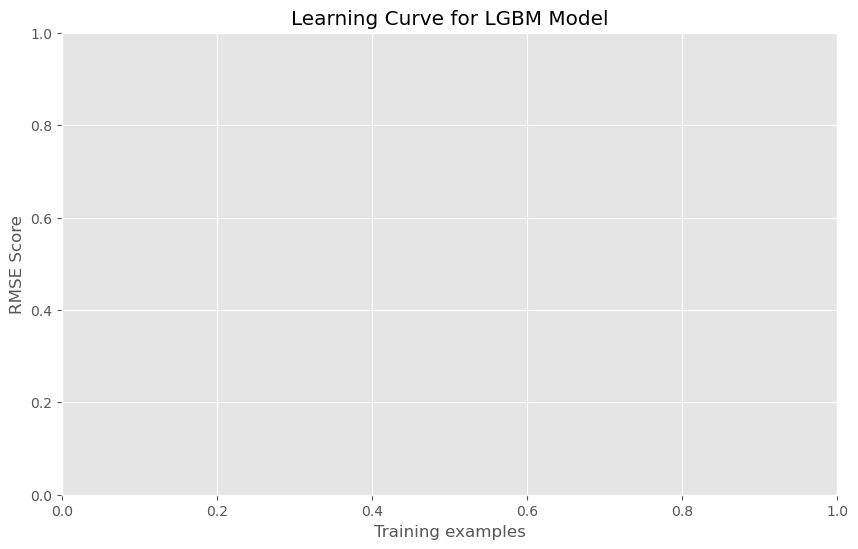

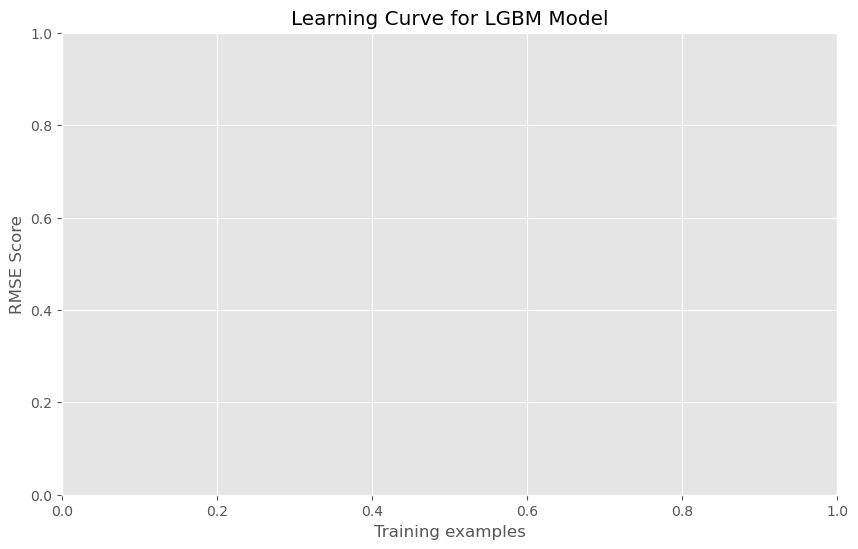

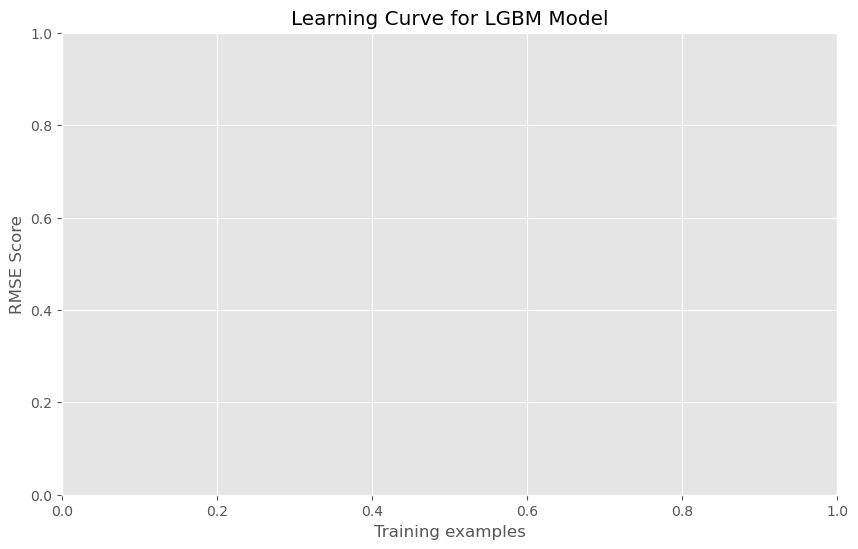

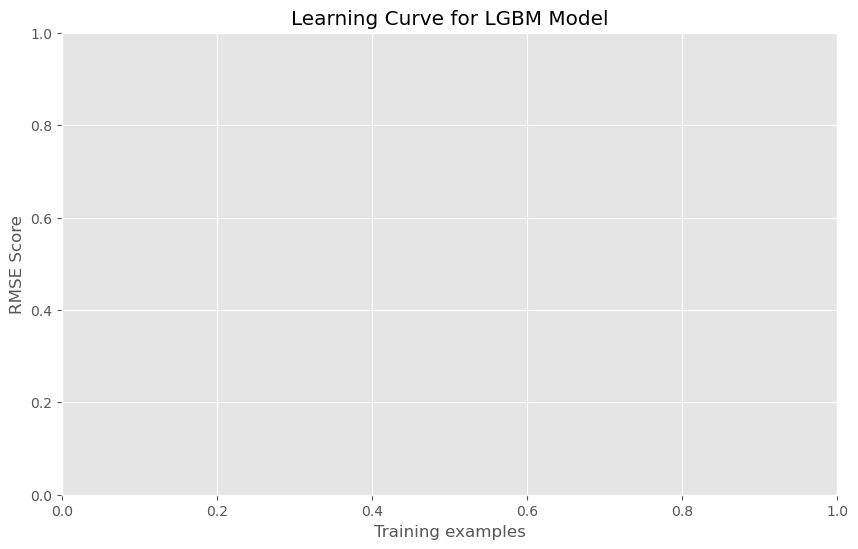

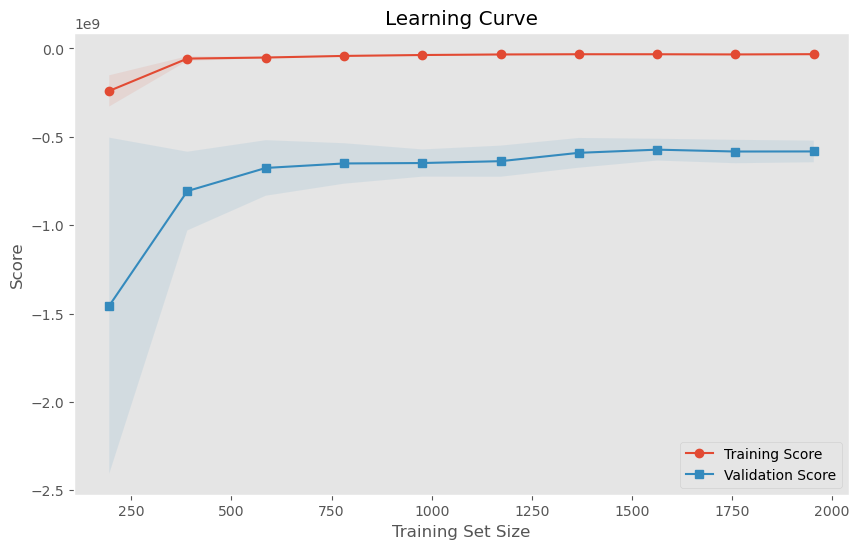

In [55]:
# Assuming you have your model already defined
plot_learning_curve(grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

In [107]:
# Modify the pipeline to use the custom objective directly
lgbm_custom_loss_tuned_pipeline = Pipeline([
    ('imputer', LotFrontageGroupMedianImputer(group_cols=['neighborhood', 'lot_config'], target_col='lot_frontage')),
    ('feature_add_drop', Add_Drop_Attributes(proximity_data=proximity_data)),
    ('preprocessor', preprocessor),
    ('estimator', LGBMRegressor(
        objective=custom_regression_loss,
        learning_rate=0.05,
        min_child_weight=1.0,
        n_estimators=300,
        num_leaves=150
    ))  # Add best parameters from grid search
])
lgbm_custom_loss_tuned_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 2443, number of used features: 38
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

Pipeline(steps=[('imputer',
                 LotFrontageGroupMedianImputer(group_cols=['neighborhood',
                                                           'lot_config'],
                                               target_col='lot_frontage')),
                ('feature_add_drop',
                 Add_Drop_Attributes(proximity_data={'Blmngtn': 3, 'Blueste': 1,
                                                     'BrDale': 2, 'BrkSide': 4,
                                                     'ClearCr': 3, 'CollgCr': 4,
                                                     'Crawfor': 4, 'Edwards': 3,
                                                     'Gilbert': 1, 'Greens': 1,
                                                     'GrnHill': 1, 'IDOTRR': 4,
                                                     'Landmrk': 4, 'MeadowV': 3,
                                                     'Mi...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['exterior_1st', 'foundation',
                                                   'mas_vnr_type',
                                                   'season_indicator',
                                                   'lot_config'])])),
                ('estimator',
                 LGBMRegressor(learning_rate=0.05, min_child_weight=1.0,
                               n_estimators=300, num_leaves=150,
                               objective=<function custom_regression_loss at 0x3266658a0>))])

# Evaluation

In [138]:
reevaluate_models([glm_tuned_pipeline, lgbm_tuned_pipeline, lgbm_custom_loss_tuned_pipeline], X_train, y_train)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,20778.70,11.46%,8.92%,10152.69,0.93,-58.88,431754477.89
Model 2,10669.59,5.89%,4.96%,5495.32,0.98,-0.00,113840162.64
Model 3,5689.77,3.14%,1.66%,1447.88,0.99,-76.73,32373475.63


In [137]:
reevaluate_models([glm_tuned_pipeline, lgbm_tuned_pipeline, lgbm_custom_loss_tuned_pipeline], X_test, y_test)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,22488.98,12.79%,8.94%,9995.30,0.91,23.45,505754367.80
Model 2,22101.73,12.57%,9.00%,10416.65,0.91,1144.28,488486650.30
Model 3,22714.23,12.91%,9.49%,11252.90,0.90,1369.86,515936111.31


The LGBM with custom loss tends to overfit the data, and the performance is not as good as the GLM model in the test set. The custom loss function gives higher bias but lower deviance. 